In [2]:
import os
import glob
import numpy as np
import pandas as pd
from PIL import Image
import IPython.display
from collections import Counter

import librosa
import librosa.display

import soundfile as sf

from sklearn.externals import joblib

import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.applications import vgg16
from keras.models import Model

import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
%matplotlib inline


Using TensorFlow backend.


## DataSet Exploration Anlysis

In [3]:
files = glob.glob('data/UrbanSound8K/audio/fold1/*')

In [4]:
len(files)

873

In [5]:
labels_key = {'0' : 'air_conditioner', '1' : 'car_horn', '2' : 'children_playing', '3' : 'dog_bark', '4' : 'drilling', 
                 '5' : 'engine_idling', '6' : 'gun_shot', '7' : 'jackhammer', '8' : 'siren', '9' : 'street_music'}
pd.DataFrame(sorted(list(labels_key.items())))

,0,1
0,0,air_conditioner
1,1,car_horn
2,2,children_playing
3,3,dog_bark
4,4,drilling
5,5,engine_idling
6,6,gun_shot
7,7,jackhammer
8,8,siren
9,9,street_music


In [6]:
samples = [(labels_key[label], [f for f in files if f.split('-')[1] == label][0]) 
           for label in labels_key.keys()]

samples

[('air_conditioner', 'data/UrbanSound8K/audio/fold1/134717-0-0-18.wav'),
 ('car_horn', 'data/UrbanSound8K/audio/fold1/156194-1-0-0.wav'),
 ('children_playing', 'data/UrbanSound8K/audio/fold1/182800-2-2-0.wav'),
 ('dog_bark', 'data/UrbanSound8K/audio/fold1/54858-3-0-0.wav'),
 ('drilling', 'data/UrbanSound8K/audio/fold1/71087-4-1-0.wav'),
 ('engine_idling', 'data/UrbanSound8K/audio/fold1/103258-5-0-1.wav'),
 ('gun_shot', 'data/UrbanSound8K/audio/fold1/46656-6-2-0.wav'),
 ('jackhammer', 'data/UrbanSound8K/audio/fold1/180937-7-0-2.wav'),
 ('siren', 'data/UrbanSound8K/audio/fold1/157867-8-0-28.wav'),
 ('street_music', 'data/UrbanSound8K/audio/fold1/124489-9-0-17.wav')]

In [7]:
def get_sound_data(path, sr=22050):
    data, fsr = sf.read(path)
    data_22k = librosa.resample(data.T, fsr, sr)
    if len(data_22k.shape) > 1:
        data_22k = np.average(data_22k, axis=0)
    return data_22k, sr

In [8]:
sample_data = [(sample[0], get_sound_data(sample[1])) for sample in samples]

In [9]:
[(sample[0], sample[1][0].shape) for sample in sample_data]

[('air_conditioner', (88200,)),
 ('car_horn', (5513,)),
 ('children_playing', (88200,)),
 ('dog_bark', (88200,)),
 ('drilling', (17640,)),
 ('engine_idling', (88200,)),
 ('gun_shot', (33013,)),
 ('jackhammer', (88200,)),
 ('siren', (88200,)),
 ('street_music', (88200,))]

In [10]:
for data in sample_data:
    print(data[0], ':')
    IPython.display.display(IPython.display.Audio(data=data[1][0], rate=data[1][1]))

air_conditioner :


car_horn :


children_playing :


dog_bark :


drilling :


engine_idling :


gun_shot :


jackhammer :


siren :


street_music :


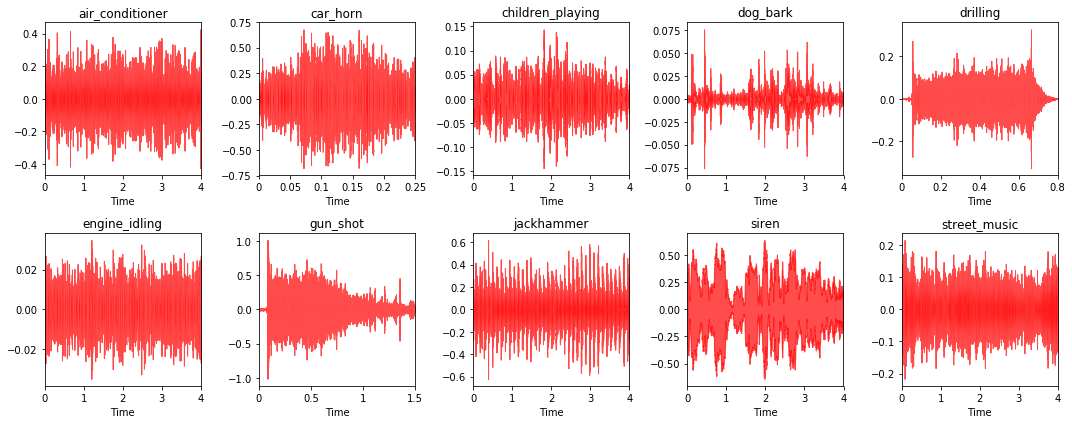

In [11]:
i = 1
fig = plt.figure(figsize=(15, 6))
for item in sample_data:
    plt.subplot(2, 5, i)
    librosa.display.waveplot(item[1][0], sr=item[1][1], color='r', alpha=0.7)
    plt.title(item[0])
    i += 1
plt.tight_layout()

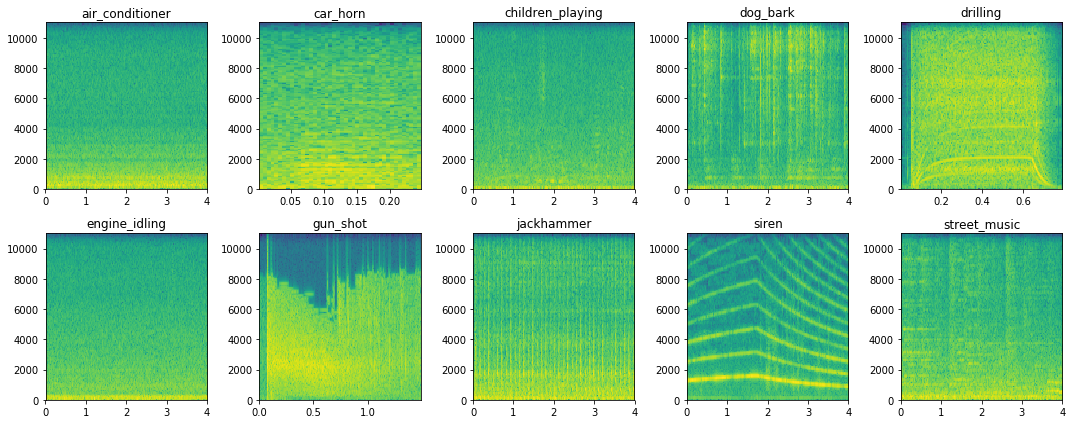

In [12]:
i = 1
fig = plt.figure(figsize=(15, 6))
for item in sample_data:
    plt.subplot(2, 5, i)
    specgram(item[1][0], Fs=item[1][1])
    plt.title(item[0])
    i += 1
plt.tight_layout()

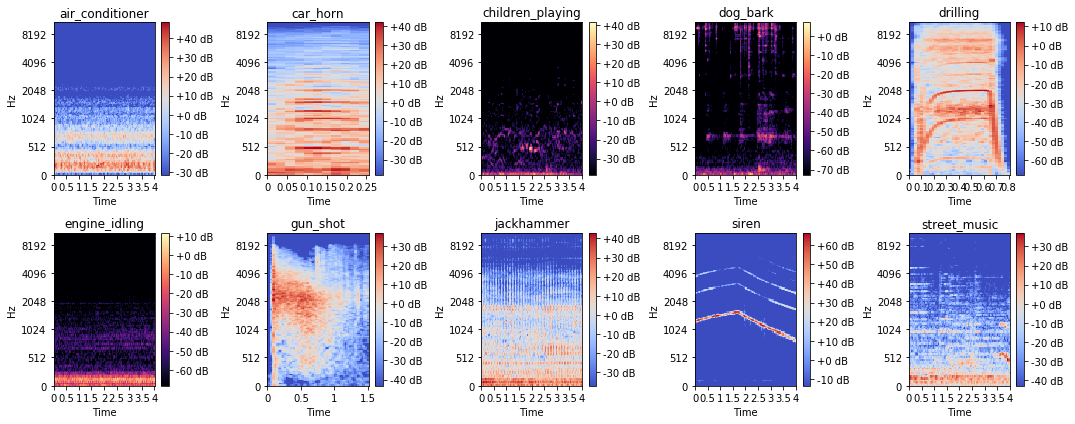

In [14]:
i = 1
fig = plt.figure(figsize=(15, 6))
for item in sample_data:
    plt.subplot(2, 5, i)
    S = librosa.feature.melspectrogram(item[1][0], sr=item[1][1], n_mels=128)
    log_S = librosa.amplitude_to_db(S)
    librosa.display.specshow(log_S, sr=item[1][1], x_axis='time', y_axis='mel')
    plt.title(item[0])
    plt.colorbar(format='%+02.0f dB')
    i += 1
plt.tight_layout()

In [15]:
y = sample_data[6][1][0]

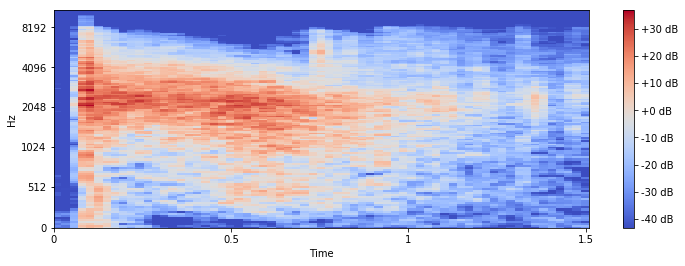

In [16]:
S = librosa.feature.melspectrogram(y, sr=22050, n_mels=128)
log_S = librosa.amplitude_to_db(S)
plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=22050, x_axis='time', y_axis='mel')
plt.colorbar(format='%+02.0f dB')
plt.show()

In [17]:
y_harmonic, y_percussive = librosa.effects.hpss(y)

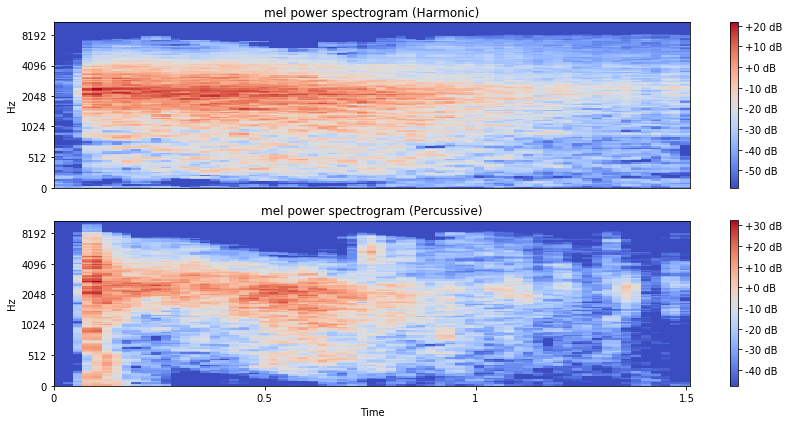

In [18]:
S_harmonic   = librosa.feature.melspectrogram(y_harmonic, sr=22050, n_mels=128)
S_percussive = librosa.feature.melspectrogram(y_percussive, sr=22050)
log_Sh = librosa.amplitude_to_db(S_harmonic)
log_Sp = librosa.amplitude_to_db(S_percussive)

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
librosa.display.specshow(log_Sh, sr=22050, y_axis='mel')
plt.title('mel power spectrogram (Harmonic)')
plt.colorbar(format='%+02.0f dB')

plt.subplot(2,1,2)
librosa.display.specshow(log_Sp, sr=22050, x_axis='time', y_axis='mel')
plt.title('mel power spectrogram (Percussive)')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

## Feature Extract Engineering

In [19]:
ROOT_DIR = 'data/UrbanSound8K/audio/'
files = glob.glob(ROOT_DIR+'/**/*')

In [20]:
len(files)

8732

In [33]:
files[0].split('\\')[-1].split('-')[1]

'0'

In [34]:
def get_sound_data(path, sr=22050):
    data, fsr = sf.read(path)
    data_resample = librosa.resample(data.T, fsr, sr)
    if len(data_resample.shape) > 1:
        data_resample = np.average(data_resample, axis=0)
    return data_resample, sr

def windows(data, window_size):
    start = 0
    while start < len(data):
        yield int(start), int(start + window_size)
        start += (window_size / 2)

In [35]:
d, sr = get_sound_data(files[0])

In [36]:
len(d), sr

(88200, 22050)

In [37]:
list(windows(d, window_size=512*63))

[(0, 32256),
 (16128, 48384),
 (32256, 64512),
 (48384, 80640),
 (64512, 96768),
 (80640, 112896)]

In [38]:
32256 / 22050

1.4628571428571429

In [ ]:
def extract_features(file_names, bands=64, frames=64):
    
    window_size = 512 * (frames - 1)  
    log_specgrams_full = []
    log_specgrams_hp = []
    class_labels = []

    for fn in file_names:
        file_name = fn.split('\\')[-1]
        class_label = file_name.split('-')[1]
        sound_data, sr = get_sound_data(fn, sr=22050)

        for (start,end) in windows(sound_data, window_size):
            if(len(sound_data[start:end]) == window_size):
                signal = sound_data[start:end]
                melspec_full = librosa.feature.melspectrogram(signal, n_mels = bands)
                logspec_full = librosa.amplitude_to_db(melspec_full)
                logspec_full = logspec_full.T.flatten()[:, np.newaxis].T
                y_harmonic, y_percussive = librosa.effects.hpss(signal)
                melspec_harmonic = librosa.feature.melspectrogram(y_harmonic, n_mels = bands)
                melspec_percussive = librosa.feature.melspectrogram(y_percussive, n_mels = bands)
                logspec_harmonic = librosa.amplitude_to_db(melspec_harmonic)
                logspec_percussive = librosa.amplitude_to_db(melspec_percussive)
                logspec_harmonic = logspec_harmonic.T.flatten()[:, np.newaxis].T
                logspec_percussive = logspec_percussive.T.flatten()[:, np.newaxis].T
                logspec_hp = np.average([logspec_harmonic, logspec_percussive], axis=0)
                
                log_specgrams_full.append(logspec_full)
                log_specgrams_hp.append(logspec_hp)
                class_labels.append(class_label)
              
    log_specgrams_full = np.asarray(log_specgrams_full).reshape(len(log_specgrams_full), bands ,frames, 1)
    log_specgrams_hp = np.asarray(log_specgrams_hp).reshape(len(log_specgrams_hp), bands ,frames, 1)
    features = np.concatenate((log_specgrams_full, 
                               log_specgrams_hp, 
                               np.zeros(np.shape(log_specgrams_full))), 
                              axis=3)
 
    for i in range(len(features)):
        features[i, :, :, 2] = librosa.feature.delta(features[i, :, :, 0])
    
    return np.array(features), np.array(class_labels, dtype = np.int)

features, labels = extract_features(files)


In [ ]:
features.shape, labels.shape

In [ ]:
Counter(labels)

In [ ]:
labels_key = {'0' : 'air_conditioner', '1' : 'car_horn', '2' : 'children_playing', '3' : 'dog_bark', '4' : 'drilling', 
                 '5' : 'engine_idling', '6' : 'gun_shot', '7' : 'jackhammer', '8' : 'siren', '9' : 'street_music'}
     

categories = list(set(labels))
sample_idxs = [np.where(labels == label_id)[0][0] for label_id in categories]
feature_samples = features[sample_idxs]
feature_samples.shape

In [ ]:
plt.figure(figsize=(16, 4))
for index, (feature_map, category) in enumerate(zip(feature_samples, categories)):
    plt.subplot(2, 5, index+1)
    plt.imshow(np.concatenate((feature_map[:,:,0], feature_map[:,:,1], feature_map[:,:,2]), axis=1), cmap='viridis')
    plt.title(class_map[str(category)])
plt.tight_layout()
t = plt.suptitle('Visualizing Feature Maps for Audio Clips')

In [ ]:
joblib.dump(features, 'data/base_features.pkl')
joblib.dump(labels, 'data/dataset_labels.pkl')

In [ ]:
features = joblib.load('data/base_features.pkl')
labels = joblib.load('data/dataset_labels.pkl')
features.shape, labels.shape

In [ ]:
data = np.array(list(zip(features, labels)))
data.shape

In [ ]:
np.random.shuffle(data)

In [ ]:
train, validate, test = np.split(data, [int(.6*len(data)), int(.8*len(data))])

In [ ]:
train.shape, validate.shape, test.shape

In [ ]:
print('Train:', Counter(item[1] for item in train), 
      '\nValidate:', Counter(item[1] for item in validate), 
      '\nTest:',Counter(item[1] for item in test))

In [ ]:
def process_sound_data(data):
    data = np.expand_dims(data, axis=0)
    data = preprocess_input(data)
    return data

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=(64, 64, 3))


output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)

model = Model(vgg.input, output)
model.trainable = False

model.summary()

In [ ]:
def extract_tl_features(model, base_feature_data):
    dataset_tl_features = []
    for index, feature_data in enumerate(base_feature_data):
        if (index+1) % 1000 == 0:
            print('Finished processing', index+1, 'sound feature maps')
        pr_data = process_sound_data(feature_data)
        tl_features = model.predict(pr_data)
        tl_features = np.reshape(tl_features, tl_features.shape[1])
        dataset_tl_features.append(tl_features)
    return np.array(dataset_tl_features)

In [ ]:
train_base_features = [item[0] for item in train]
train_labels = np.array([item[1] for item in train])
train_tl_features = extract_tl_features(model=model, base_feature_data=train_base_features)

In [ ]:
joblib.dump(train_tl_features, 'data/train_tl_features.pkl')
joblib.dump(train_labels, 'data/train_labels.pkl')

In [ ]:
train_tl_features.shape, train_labels.shape

In [ ]:
validate_base_features = [item[0] for item in validate]
validate_labels = np.array([item[1] for item in validate])
validate_tl_features = extract_tl_features(model=model, base_feature_data=validate_base_features)

In [ ]:
joblib.dump(validate_tl_features, 'data/validate_tl_features.pkl')
joblib.dump(validate_labels, 'data/validate_labels.pkl')

In [ ]:
test_base_features = [item[0] for item in test]
test_labels = np.array([item[1] for item in test])
test_tl_features = extract_tl_features(model=model, base_feature_data=test_base_features)

In [ ]:
joblib.dump(test_tl_features, 'data/test_tl_features.pkl')
joblib.dump(test_labels, 'data/test_labels.pkl')

In [ ]:
train_tl_features.shape, validate_tl_features.shape, test_tl_features.shape